# AnoGAN
<hr/>

#### Parameter 조정
- epochs: 높을 때 보다 낮을 때가 좋았으며, 100 과 64 비교 시 structure 모양에 따라 각각 anomaly score의 차이가 다름
- learning_rate: 1e-5 => 2e-1 (큰 차이는 없지만 2e-1)이 조금 더 나음
- learning_G_per_D: 1 일 때가 가장 좋은 결과 값이 나옴
- 마지막 test 사진은, 정확도가 떨어짐
- 구조가 복잡한 건 잘 잡히지 않음

#### parameter
- 2020.08.16
> latent_size = 100  
> workers = 4 
> img_size = 64  
> channel = 1  
> epochs = 100  
> batch_size = 64  
> **learning_rate = 2e-1  
> learning_G_per_D = 1**


# Module

In [6]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [7]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 2e-1

# Data and Device

In [13]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
# data_root = "../../dataset/train"
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# Model

In [14]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),/ learning_rate: 2e -1
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [15]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train

In [16]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [17]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 1)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3858 / G_loss : 0.0000
- D(x) : 0.5011 / D(G(z1)) : 0.5008 / D(G(z2)) : 1.0000
[1/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][9/14]
- D_loss : 100.0

[6/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[7/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[7/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[7/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[7/100][3/14]
- D_loss :

[12/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][9/14]
- D_

[17/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[18/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[18/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[18/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[18/100][3/14]


[23/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][9/14]
- D_

[28/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[29/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[29/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[29/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[29/100][3/14]


[34/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[34/100][9/14]
- D_

[39/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[40/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[40/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[40/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[40/100][3/14]


[45/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[45/100][9/14]
- D_

[50/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[50/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[50/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[50/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[50/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[50/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[51/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[51/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[51/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[51/100][3/14]


[56/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[56/100][9/14]
- D_

[61/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[61/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[61/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[61/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[61/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[61/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][3/14]


[67/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][9/14]
- D_

[72/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[72/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[72/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[72/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[72/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[72/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][3/14]


[78/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][9/14]
- D_

[83/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[84/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[84/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[84/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[84/100][3/14]


[89/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[89/100][9/14]
- D_

[94/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[94/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[94/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[94/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[94/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[94/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[95/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[95/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[95/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[95/100][3/14]


[100/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[100/100][

# Graph

In [18]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

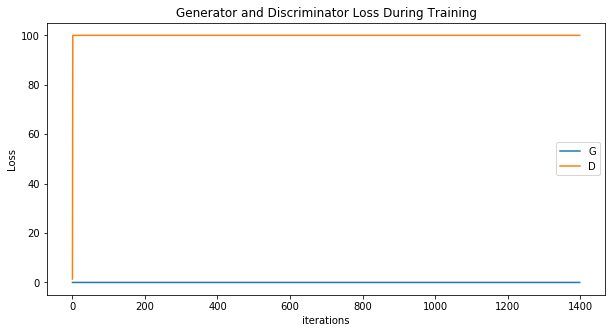

In [19]:
plot_train_loss()

# Animation

In [20]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

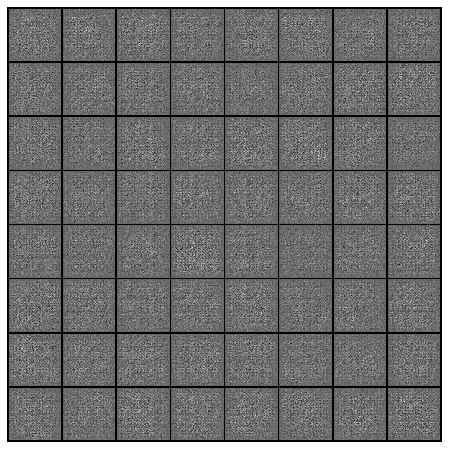

In [21]:
animate_gen_imgs()

# Anomaly Loss

In [22]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature =  D(Test_Data)
    _, G_Data_feature    =  D(G_Data)
    residual_loss        =  torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss  =  torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss             =  (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_Ti64"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [23]:
latent_space = []
auc=[]

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [24]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 982.9644  Sum_of_z : 13.0537
[200]	 Ano_loss : 941.8345  Sum_of_z : 16.2879
[400]	 Ano_loss : 939.2179  Sum_of_z : 13.8769
picture  2
[0]	 Ano_loss : 1594.5518  Sum_of_z : 13.8937
[200]	 Ano_loss : 1566.0154  Sum_of_z : 7.9398
[400]	 Ano_loss : 1565.4449  Sum_of_z : 7.1187
picture  3
[0]	 Ano_loss : 1432.6077  Sum_of_z : 6.9856
[200]	 Ano_loss : 1390.1414  Sum_of_z : 1.3977
[400]	 Ano_loss : 1389.1720  Sum_of_z : 1.9194
picture  4
[0]	 Ano_loss : 1543.7893  Sum_of_z : 1.9228
[200]	 Ano_loss : 1501.1134  Sum_of_z : -3.2086
[400]	 Ano_loss : 1498.6482  Sum_of_z : -2.7105
picture  5
[0]	 Ano_loss : 1508.5756  Sum_of_z : -2.6264
[200]	 Ano_loss : 1443.5587  Sum_of_z : 11.6291
[400]	 Ano_loss : 1443.0969  Sum_of_z : 14.8149
picture  6
[0]	 Ano_loss : 1603.7438  Sum_of_z : 14.8463
[200]	 Ano_loss : 1542.2551  Sum_of_z : 21.6210
[400]	 Ano_loss : 1541.0953  Sum_of_z : 20.3413
picture  7
[0]	 Ano_loss : 616.6589  Sum_of_z : 20.1413
[200]	 Ano_loss : 532.9676  Sum_of_

# Similar Z , Ano_Score and Segementation

In [25]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

In [26]:
diff_cnts = []

def compare_imgs(real_img, generated_img,i, reverse=False, threshold=50):
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

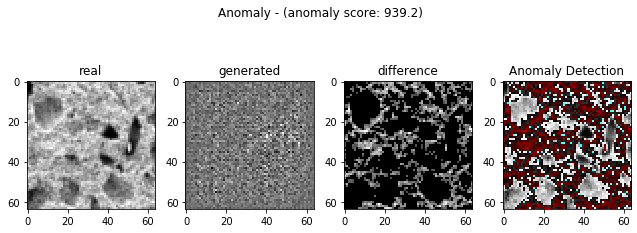

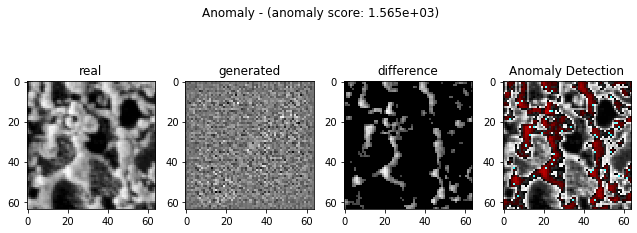

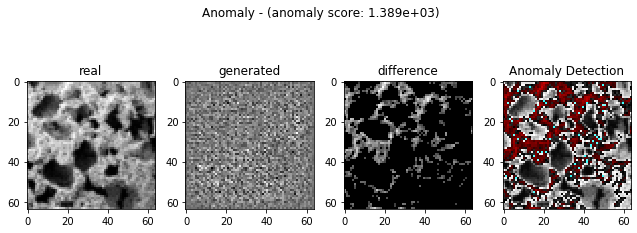

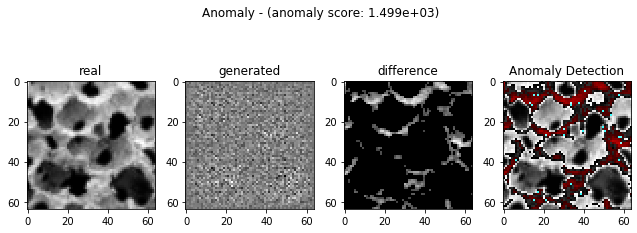

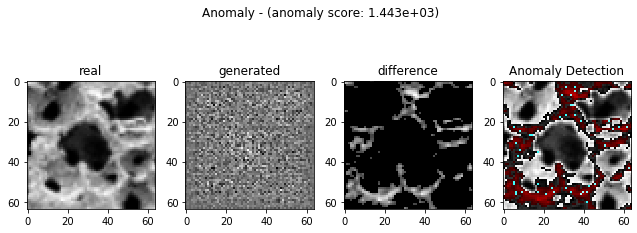

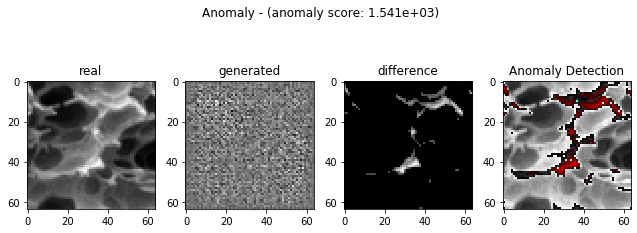

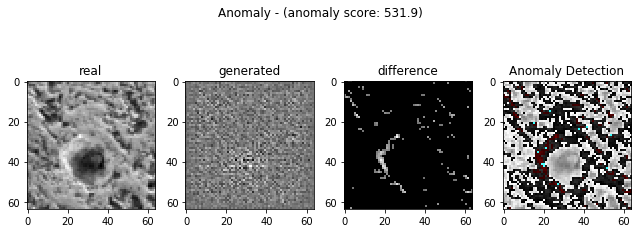

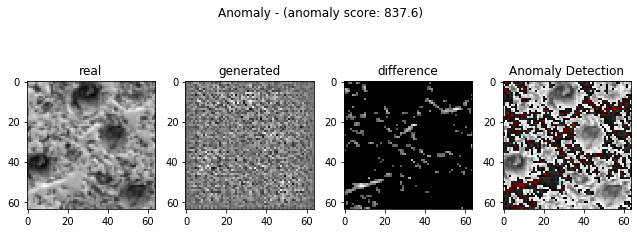

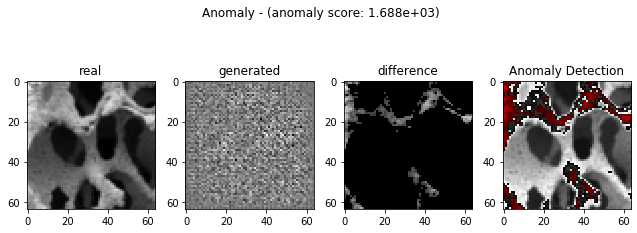

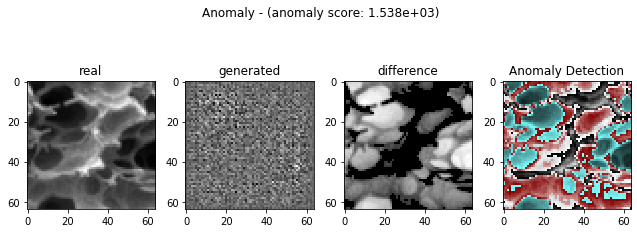

In [27]:
vali_label = [0,0,0,0,0,1,1,1,1,1,1]

for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

# 분율 측정

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.35961914 0.2097168  0.24902344 0.18579102 0.21801758 0.06567383
 0.046875   0.09667969 0.12280273 0.70239258]


# AnoGAN 성능 확인: 상대밀도

In [29]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.59311279 0.92904541 1.10317383 0.8230542  0.96581787 0.29093506
 0.20765625 0.42829102 0.54401611 3.11159912]


### 분율 평균

In [30]:
# 상대 밀도 평균
print(sum(Ti64_rel_densitys)/len(Ti64_rel_densitys))

0.9996701660156248


In [31]:
# 분율 평균
print(sum(diff_fraction)/len(diff_fraction))

0.2256591796875
